In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image

%matplotlib inline

## Data Download and cleaning

In [2]:
rawData = pd.read_csv('../data/trenes-despachados.csv', sep = ';')
rawData.drop(['FR1_REGIST','FR1_KM','FR1_KMV'], axis = 1, inplace = True)
rawData.columns = ['date','line','dayType','travelId','trainId',
                   'notDispach1','notDispach1Details','notDispach2','notDispach2Details',
                  'amountCars1','amountCars2','dispached1','dispached2',
                  'time1','time2']
# split data into two dataframes, one for each terminal

t1 = rawData.drop(['notDispach2','notDispach2Details','amountCars2','dispached2','time2'], axis = 1)
t1['terminal']=1

t2 = rawData.drop(['notDispach1','notDispach1Details','amountCars2','dispached1','time1'], axis = 1)
t2['terminal']=2

#remane columns
t1.columns = ['date','line','dayType','travelId','trainId','notDispach',
              'notDispachDetails','amountCars','dispached','time','terminal']
t2.columns = t1.columns 


# join by rows

cleanData = t1.append(t2,ignore_index=True).reindex()

#format times
cleanData['depart'] = cleanData.date + ' ' + cleanData.time
cleanData.date = pd.to_datetime(cleanData.date, format='%d/%m/%Y')
cleanData.depart = pd.to_datetime(cleanData.depart, format='%d/%m/%Y %H:%M:%S')


#sort values for lag
cleanData.sort_values(by=['line','terminal','depart'],inplace=True)
cleanData.reset_index(drop=True, inplace=True)

#only dispatched trains
delayData = cleanData.loc[cleanData.dispached == 'S' ,['line','depart']].copy()
delayData['departLag'] = delayData.depart.shift(1)
delayData['delay'] = delayData.depart - delayData.departLag

#create days of each depart, a variable stating wich delays are between diferent days, removing those delay times
delayData['departDay'] = delayData.depart.map(lambda x: x.day)
delayData['departLagDay'] = delayData.departLag.map(lambda x: x.day)
delayData['departDifferentDay'] = ~(delayData.departDay == delayData.departLagDay)
delayData.delay[delayData.departDifferentDay] = pd.NaT
delayData.drop(['departDay','departLag','departLagDay','departDifferentDay'], axis = 1 , inplace=True)



#remove outliers based on each line top 0.5%
delayData.groupby(by=delayData.line)
delayByLineOutliers = delayData.delay[~delayData.delay.isnull()].groupby(by=delayData.line).quantile(0.995)


delayDataA = delayData[delayData.line == 'A']
delayDataA.delay[delayDataA.delay > delayByLineOutliers['A']] =  pd.NaT

delayDataB = delayData[delayData.line == 'B']
delayDataB.delay[delayDataB.delay > delayByLineOutliers['B']] =  pd.NaT

delayDataC = delayData[delayData.line == 'C']
delayDataC.delay[delayDataC.delay > delayByLineOutliers['C']] =  pd.NaT

delayDataD = delayData[delayData.line == 'D']
delayDataD.delay[delayDataD.delay > delayByLineOutliers['D']] =  pd.NaT

delayDataE = delayData[delayData.line == 'E']
delayDataE.delay[delayDataE.delay > delayByLineOutliers['E']] =  pd.NaT

delayDataH = delayData[delayData.line == 'H']
delayDataH.delay[delayDataH.delay > delayByLineOutliers['H']] =  pd.NaT

delayDataP = delayData[delayData.line == 'P']
delayDataP.delay[delayDataP.delay > delayByLineOutliers['P']] =  pd.NaT

#Append in a full dataset

delayDataFinal = delayDataA.append(delayDataB)
delayDataFinal = delayDataFinal.append(delayDataC)
delayDataFinal = delayDataFinal.append(delayDataD)
delayDataFinal = delayDataFinal.append(delayDataE)
delayDataFinal = delayDataFinal.append(delayDataH)
delayDataFinal = delayDataFinal.append(delayDataP)


#convert timedelta into integers en create a month category, remove unnecesary columns
delayDataFinal['delayInt'] = delayDataFinal.delay / np.timedelta64(1, 'm')
delayDataFinal['month'] = delayDataFinal.depart.map(lambda x:  str(x.year) + '-' + str(x.month))
delayDataFinal['year'] = delayDataFinal.depart.map(lambda x: x.year)
delayDataFinal['month2'] = delayDataFinal.depart.map(lambda x: x.month)

delayDataFinal['departHour'] = delayDataFinal.depart.map(lambda x: x.hour)
delayDataFinal.drop(['line','depart'], axis = 1 , inplace=True)




# Merge into subway final data
subwayData = pd.merge(cleanData,delayDataFinal,how='left',left_index=True, right_index=True)


/home/pipe/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/pipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/pipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/pipe/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [3]:
subwayData.delayInt[~subwayData.delayInt.isnull()].describe()

count    1.664808e+06
mean     5.581659e+00
std      2.481594e+00
min      0.000000e+00
25%      3.650000e+00
50%      4.900000e+00
75%      7.150000e+00
max      2.900000e+01
Name: delayInt, dtype: float64

In [4]:
#colors for each line 
lineColors = {'A':'dodgerblue','B':'red','C':'mediumblue','D':'forestgreen','E':'purple','H':'yellow','P':'coral'}

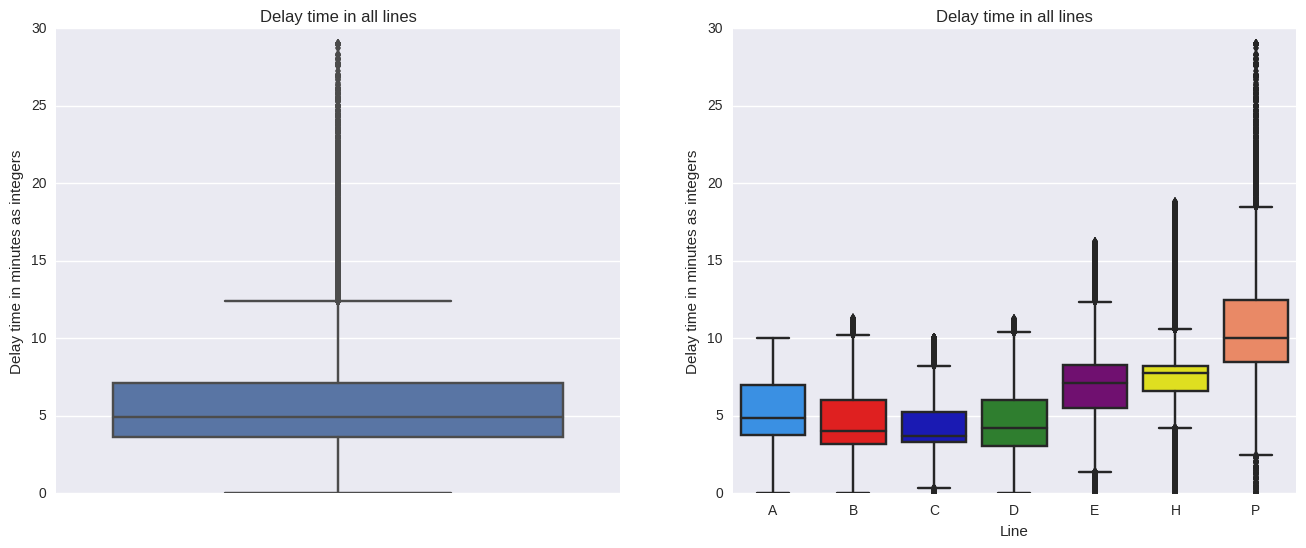

In [5]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax = sns.boxplot(subwayData.delayInt,orient = 'v')
ax.set_title('Delay time in all lines')
ax.set_ylabel('Delay time in minutes as integers')

ax2 = fig.add_subplot(1,2,2)
ax2 = sns.boxplot(subwayData.line,subwayData.delayInt,palette=lineColors)
ax2.set_title('Delay time in all lines')
ax2.set_ylabel('Delay time in minutes as integers')
ax2.set_xlabel('Line')

## Figure 1
The first plot shows that the median waiting time between one train and the other in the BA subway as a whole, is 5 minutes. This changes when we take a look to what happens on a line by line basis. The **C** line is the line with the best frequency (*3:41 minutes*). Next is the **B** line (*04:07 minutes*) followed closely by the **D** line (*04:15 minutes*). Also within 4 minutes, we find the the **A** line (*04:53 minutes*). Already in the 7 minutes we hace the **E** line (*07:10 minutes*) and the the **H** line (*7:30 minutes*). Finally the **P** line (*10 minutes*).

In [6]:
lines = subwayData.line.unique()
waitingTimeByLine = subwayData.delay.groupby(by=subwayData.line).describe()
for line in lines:
    print line,'median:',waitingTimeByLine[line]['50%'],line,'mean:',waitingTimeByLine[line]['mean']

A median: 0 days 00:04:53 A mean: 0 days 00:05:24.014990
B median: 0 days 00:04:00 B mean: 0 days 00:04:36.558531
C median: 0 days 00:03:41 C mean: 0 days 00:04:22.766581
D median: 0 days 00:04:11 D mean: 0 days 00:04:34.480072
E median: 0 days 00:07:08 E mean: 0 days 00:07:10.792649
H median: 0 days 00:07:46 H mean: 0 days 00:07:53.597275
P median: 0 days 00:10:00 P mean: 0 days 00:10:45.417884


Now, Mayor Larreta's public commitment was to reduce the waiting time for each subway to 3 minutes during roush hour. Classic rush hours can be defined between 8 and 10 am for the morning rush hour and between 5 to 7 pm for the evening rush hour. Also, it is necessary to take into account the terminal stations where we measure the waiting time. Buenos Aires City has a radial shape with a clear defined center. Over this underlying functional reality of the urban space, the subway lines were designed with two distintc types: **radial lines** (*A,B,D,E,P*), which connect city center with the most peripheral neighborhoods; and **circumferential lines** (only *C* and *H*), which go around city center and intersect the remaining lines perpendicularly. Therefore, while in the **circumferential lines** both rush hours periods are important (morning and evening) when considering the waiting time for a subway train, in the **radial lines** the really important one changes accordingly to the time of day. We want to check the waiting time on the peripheral terminal stations during the morning rush and on the center terminal stations during the evening rush.

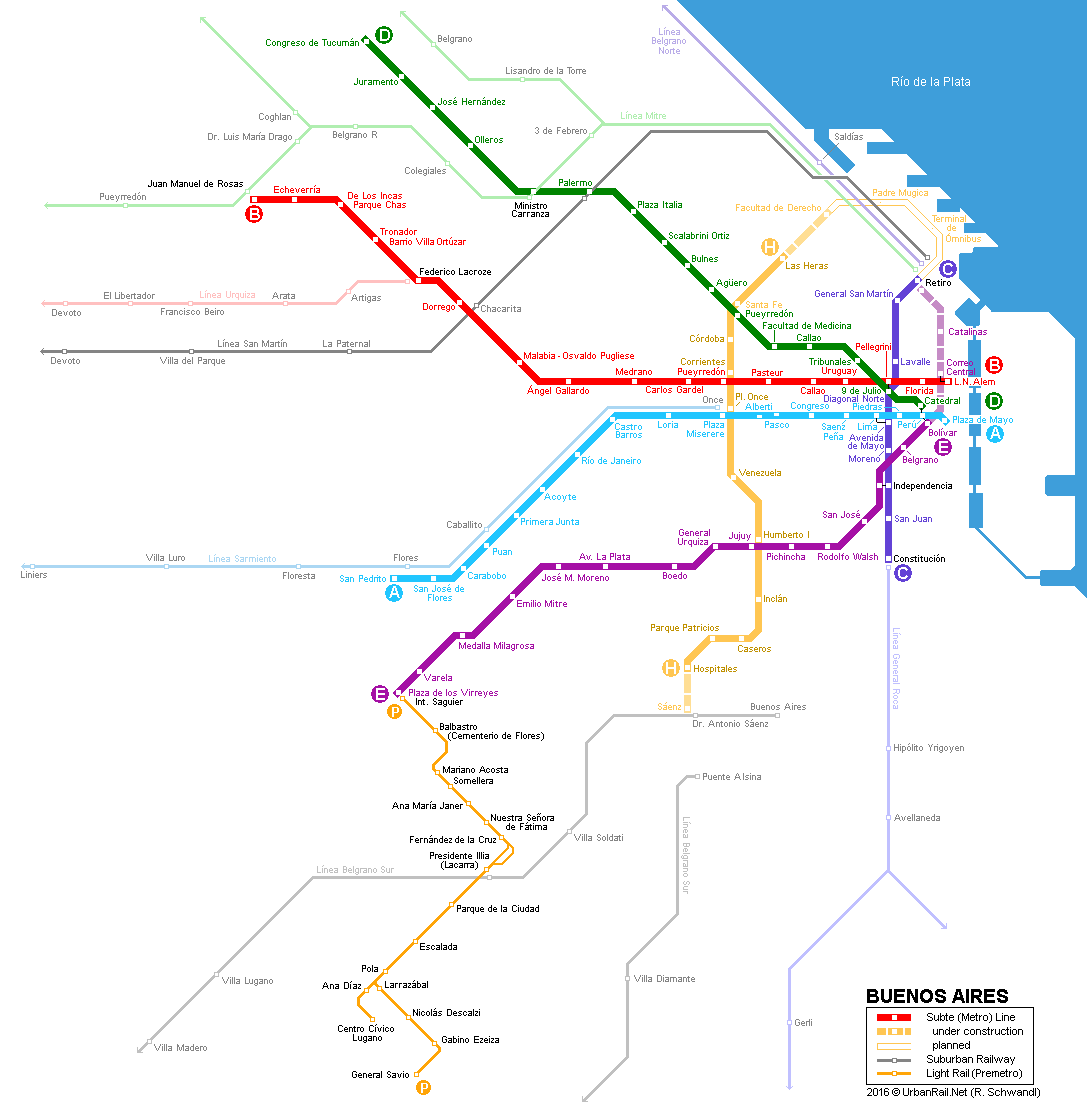

In [7]:
Image("../img/baSubwayMap.png")

## Figure 2 - Buenos Aires Subway Map


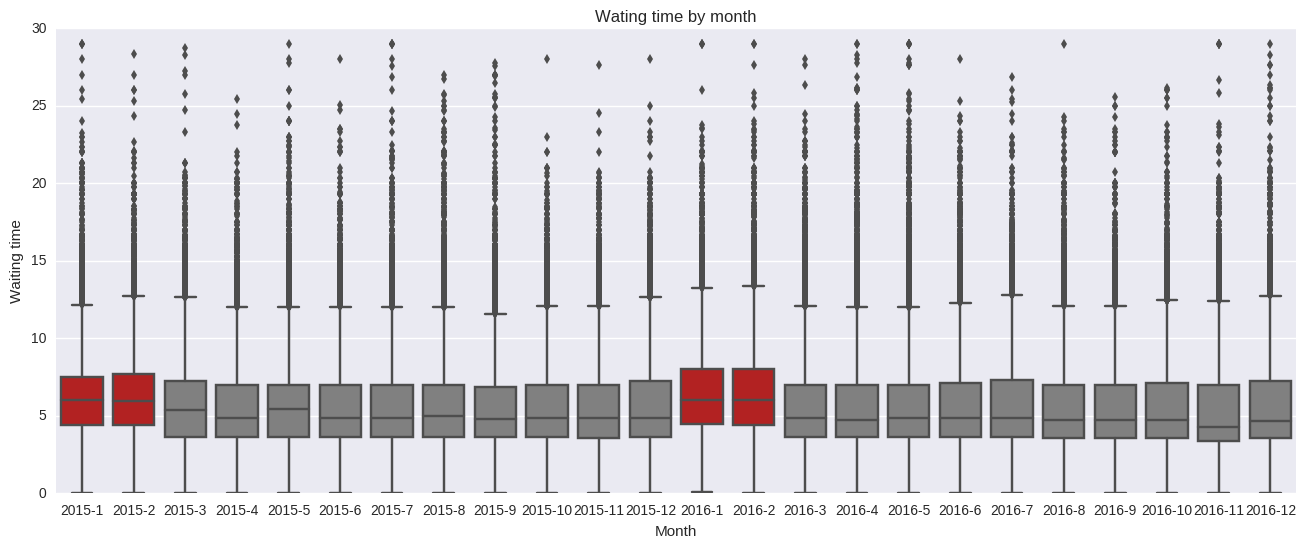

In [8]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,1,1)
ax = sns.boxplot(subwayData.month,subwayData.delayInt,color='grey')
ax.artists[0].set_facecolor('firebrick')
ax.artists[1].set_facecolor('firebrick')
ax.artists[12].set_facecolor('firebrick')
ax.artists[13].set_facecolor('firebrick')

ax.set_title('Wating time by month')
ax.set_xlabel('Month')
ax.set_ylabel('Waiting time')

## Figure 3
The plot shows that during January and February, the most frequent holiday months in Argentina, waiting time increases, but afterwards, rapidly converge towards the 5 minutes median waiting time. There is no clear tendency of decreasing time towards the 3 minute goal, taking all the lines, in all the terminals during every hour. It remains to be seen if, after accounting for the terminals and rush hours, this goal is reached.

In [9]:
#create masks for rush hours during workdays 
workdayNotNan = (subwayData.dayType == 'H') &  (~subwayData.delay.isnull())
subwayData['rushMorning'] = (subwayData.departHour >= 8) & (subwayData.departHour <= 10) & workdayNotNan 
subwayData['rushEvening'] = (subwayData.departHour >= 17) & (subwayData.departHour <= 19) & workdayNotNan

In [10]:
print subwayData.shape
waitingTime = subwayData.copy().loc[subwayData.rushEvening |subwayData.rushMorning,['line','month','terminal','delay','delayInt','rushMorning','rushEvening']]
waitingTimeNew = subwayData.copy().loc[subwayData.rushEvening |subwayData.rushMorning,['line','month','year','month2','terminal','delay','delayInt','rushMorning','rushEvening']]
print waitingTime.shape
waitingTime.head()

(1965976, 20)
(509063, 7)


,line,month,terminal,delay,delayInt,rushMorning,rushEvening
493,A,2015-1,1,00:04:00,4.00,True,False
494,A,2015-1,1,00:03:45,3.75,True,False
495,A,2015-1,1,00:04:00,4.00,True,False
496,A,2015-1,1,00:04:09,4.15,True,False
497,A,2015-1,1,00:04:06,4.10,True,False


In [11]:
stationsNames = {'A':['','San Pedrito','Plaza de Mayo'],
                'B':['','Juan Manuel de Rosas','Leandro N. Alem'],
                'C':['','Constitucion','Retiro'],
                'D':['','Congreso de Tucuman','Catedral'],
                'E':['','Plaza de los Virreyes','Bolivar'],
                'H':['','Las Heras','Hospitales'],
                'P':['','',''],}

In [12]:
def plotLineTimeSeries(line):
    fig = plt.figure(figsize=(16,6))
    plotId = 1
    color = lineColors[line] 
    for i in [1,2]:
        terminal = stationsNames[line][i]
        
        if line == 'P' and i == 2 :
            break
            
        #print terminal 
        plotMask = (waitingTime.line == line) & (waitingTime.terminal == i)
        #print sum(plotMask), len(plotMask)
        
               
        if (line != 'C' and line != 'H'): #radial lines selection for rush hour depending on terminal
            if i == 1:
                plotMask = plotMask & waitingTime.rushMorning
                rushTime = 'Morning'
            else:
                plotMask = plotMask & waitingTime.rushEvening
                rushTime = 'Afternoon'
        else:
            plotMask = (plotMask & (waitingTime.rushEvening | waitingTime.rushMorning))
            rushTime = 'Morning and Afternoon'
           
        ax = fig.add_subplot(1,2,plotId)
        ax = sns.boxplot(waitingTime.month[plotMask],waitingTime.delayInt[plotMask],color=color)
        ax.set_xlabel('Month')
        ax.set_ylabel('Delay (minutes)')
        ax.set_xticklabels(waitingTime.month[plotMask].unique(),rotation='vertical')

        ax.set_title('Line ' + line + ' - ' + terminal + ' - ' + rushTime)
        fig.savefig('../img/plotLine' + line + '.png')
        plotId += 1

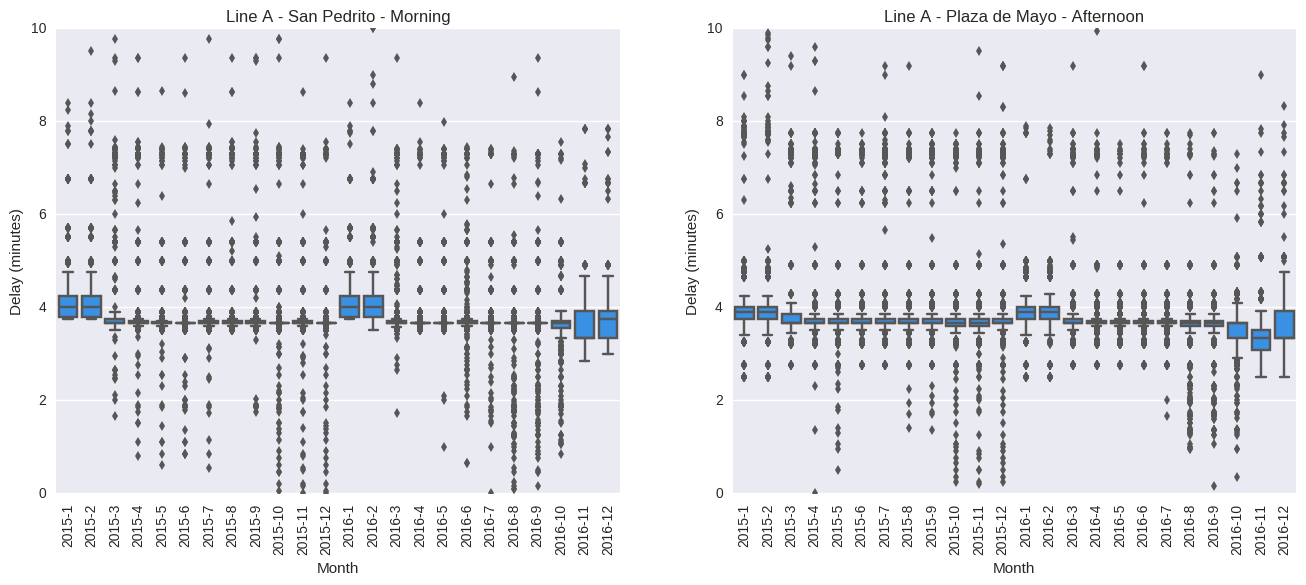

In [14]:
plotLineTimeSeries(line='A')

## Another version of ploting


In [44]:
def plotLineTimeSeries2(line,bootTraces = False):
    fig = plt.figure(figsize=(16,6))
    plotId = 1
    color = lineColors[line] 
    for i in [1,2]:
        terminal = stationsNames[line][i]
        
        if line == 'P' and i == 2 :
            break
            
        #print terminal 
        plotMask = (waitingTime.line == line) & (waitingTime.terminal == i)
        #print sum(plotMask), len(plotMask)
        
               
        if (line != 'C' and line != 'H'): #radial lines selection for rush hour depending on terminal
            if i == 1:
                plotMask = plotMask & waitingTime.rushMorning
                rushTime = 'Morning'
            else:
                plotMask = plotMask & waitingTime.rushEvening
                rushTime = 'Afternoon'
        else:
            plotMask = (plotMask & (waitingTime.rushEvening | waitingTime.rushMorning))
            rushTime = 'Morning and Afternoon'
            
        waitingTime2 = waitingTime.loc[plotMask,:]
        
        n = waitingTime2.month.value_counts().values.min()

        baseParaMergear = waitingTime2.iloc[0:1,:].copy()


        for mes in waitingTime2.month.unique():
            insumo = waitingTime2.loc[waitingTime2.month==mes,:].sample(n=n).copy()
            #print mes
            baseParaMergear = pd.concat([baseParaMergear,insumo])

        baseParaMergear.index = range(baseParaMergear.shape[0])
        baseParaMergear.drop(0,axis=0,inplace=True)
        baseParaMergear['uniqueId'] = baseParaMergear.groupby(['month']).cumcount()
        baseParaMergear.index = range(baseParaMergear.shape[0])
        
        
        
        month2 = []
        iden = 1

        for i in range(baseParaMergear.shape[0]):
            if i==0:
                month2.append(iden)
                #print iden
            else:
                if baseParaMergear.month[i] == baseParaMergear.month[i-1]:
                    month2.append(iden)
                else:
                    iden += 1
                    month2.append(iden)
                    #print iden
        baseParaMergear['month2'] = month2
        
        
        
        ax = fig.add_subplot(1,2,plotId)
        if bootTraces:
            ax = sns.tsplot(time="month2", value="delayInt",unit="uniqueId", condition="line",data=baseParaMergear,
                        color=color, err_style="boot_traces", n_boot=500)
        else:
            ax = sns.tsplot(time="month2", value="delayInt",unit="uniqueId", condition="line",data=baseParaMergear,
        ci=[50,75,95], color=color,estimator=np.median)
        

        ax.set_xlabel('Month')
        ax.set_ylabel('Delay (minutes)')
        ax.set_xticklabels(['Ene-2016','May-2015','Oct-2015','Mar-2016','Ago-2016'],rotation='vertical')

        ax.set_title('Line ' + line + ' - ' + terminal + ' - ' + rushTime)
        #fig.savefig('../img/plotLine' + line + '.png')
        plotId += 1

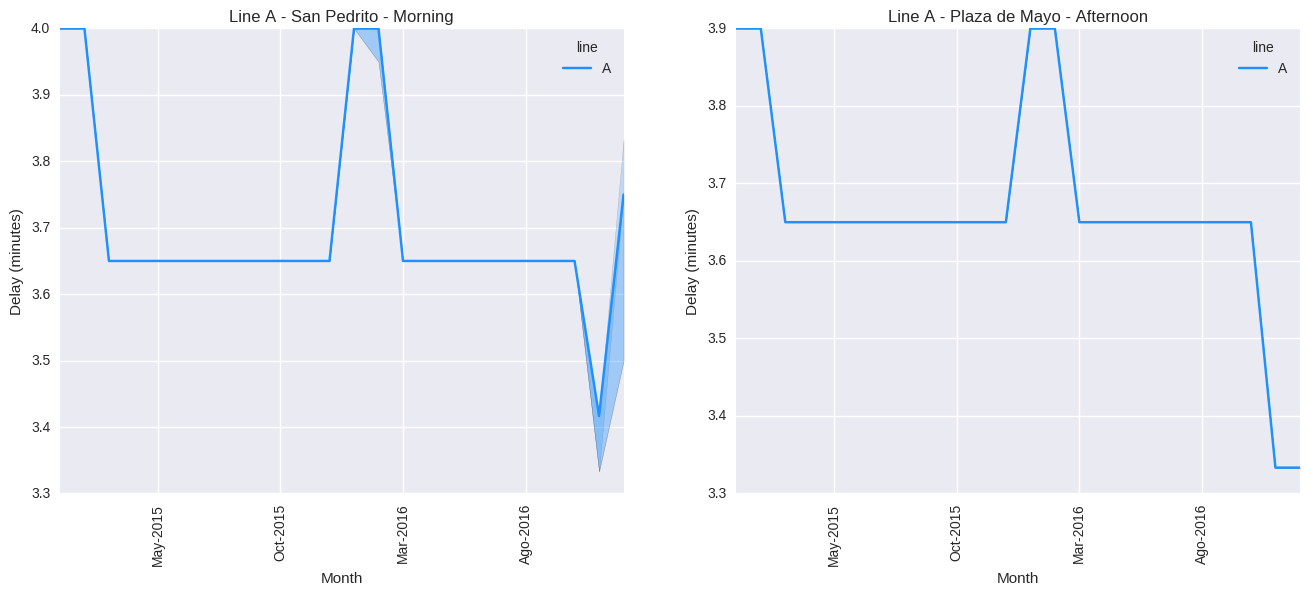

In [50]:
plotLineTimeSeries2(line='A',bootTraces = False)

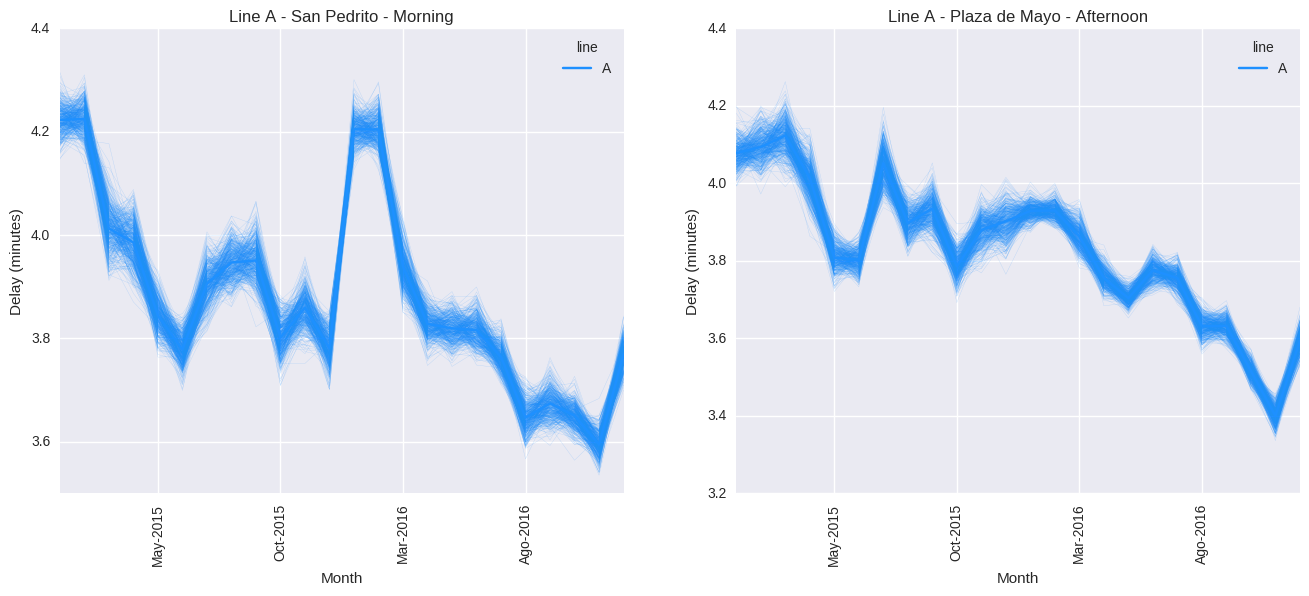

In [51]:
plotLineTimeSeries2(line='A',bootTraces = True)

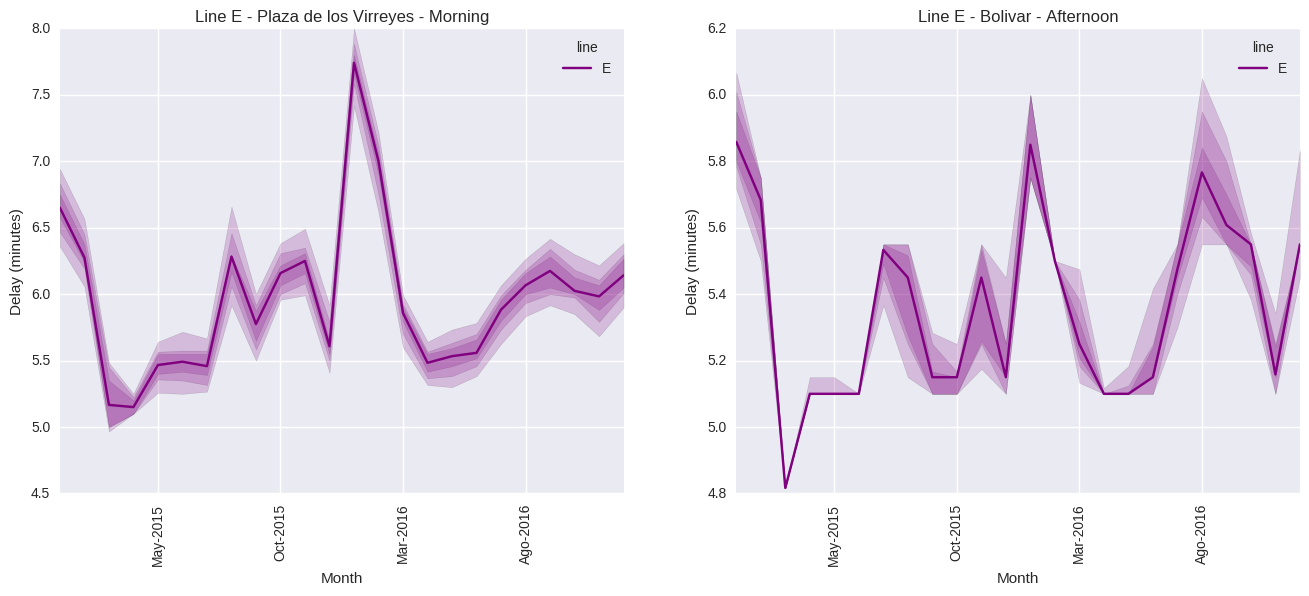

In [49]:
plotLineTimeSeries2(line='E',bootTraces = False)

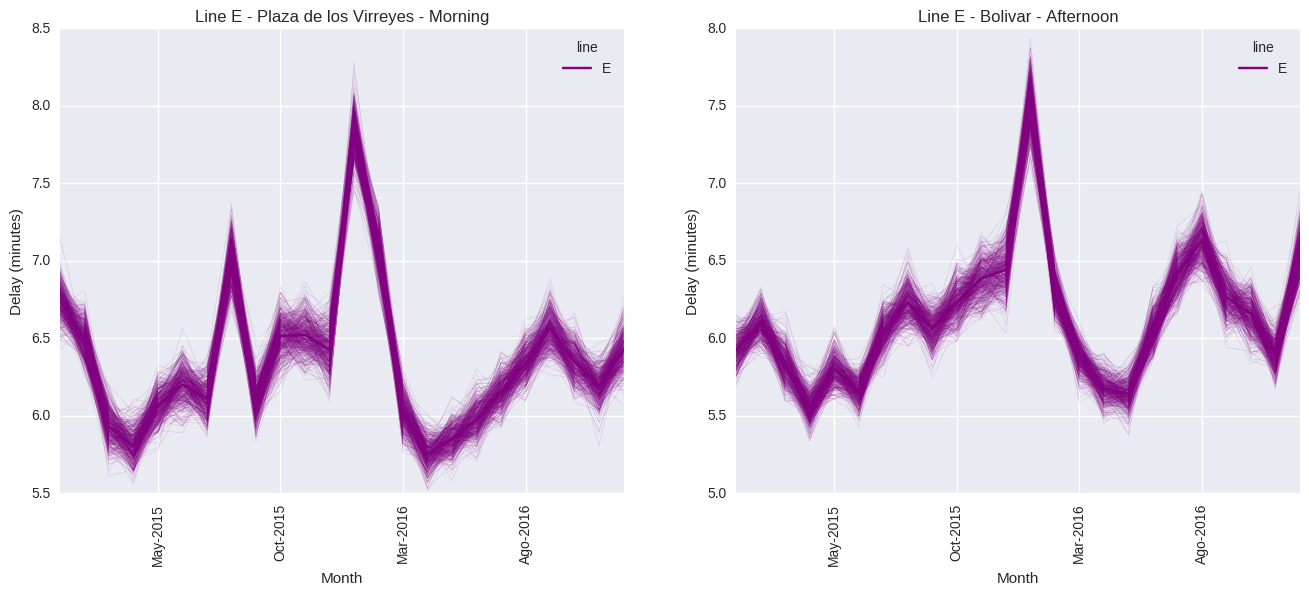

In [48]:
plotLineTimeSeries2(line='E',bootTraces = True)

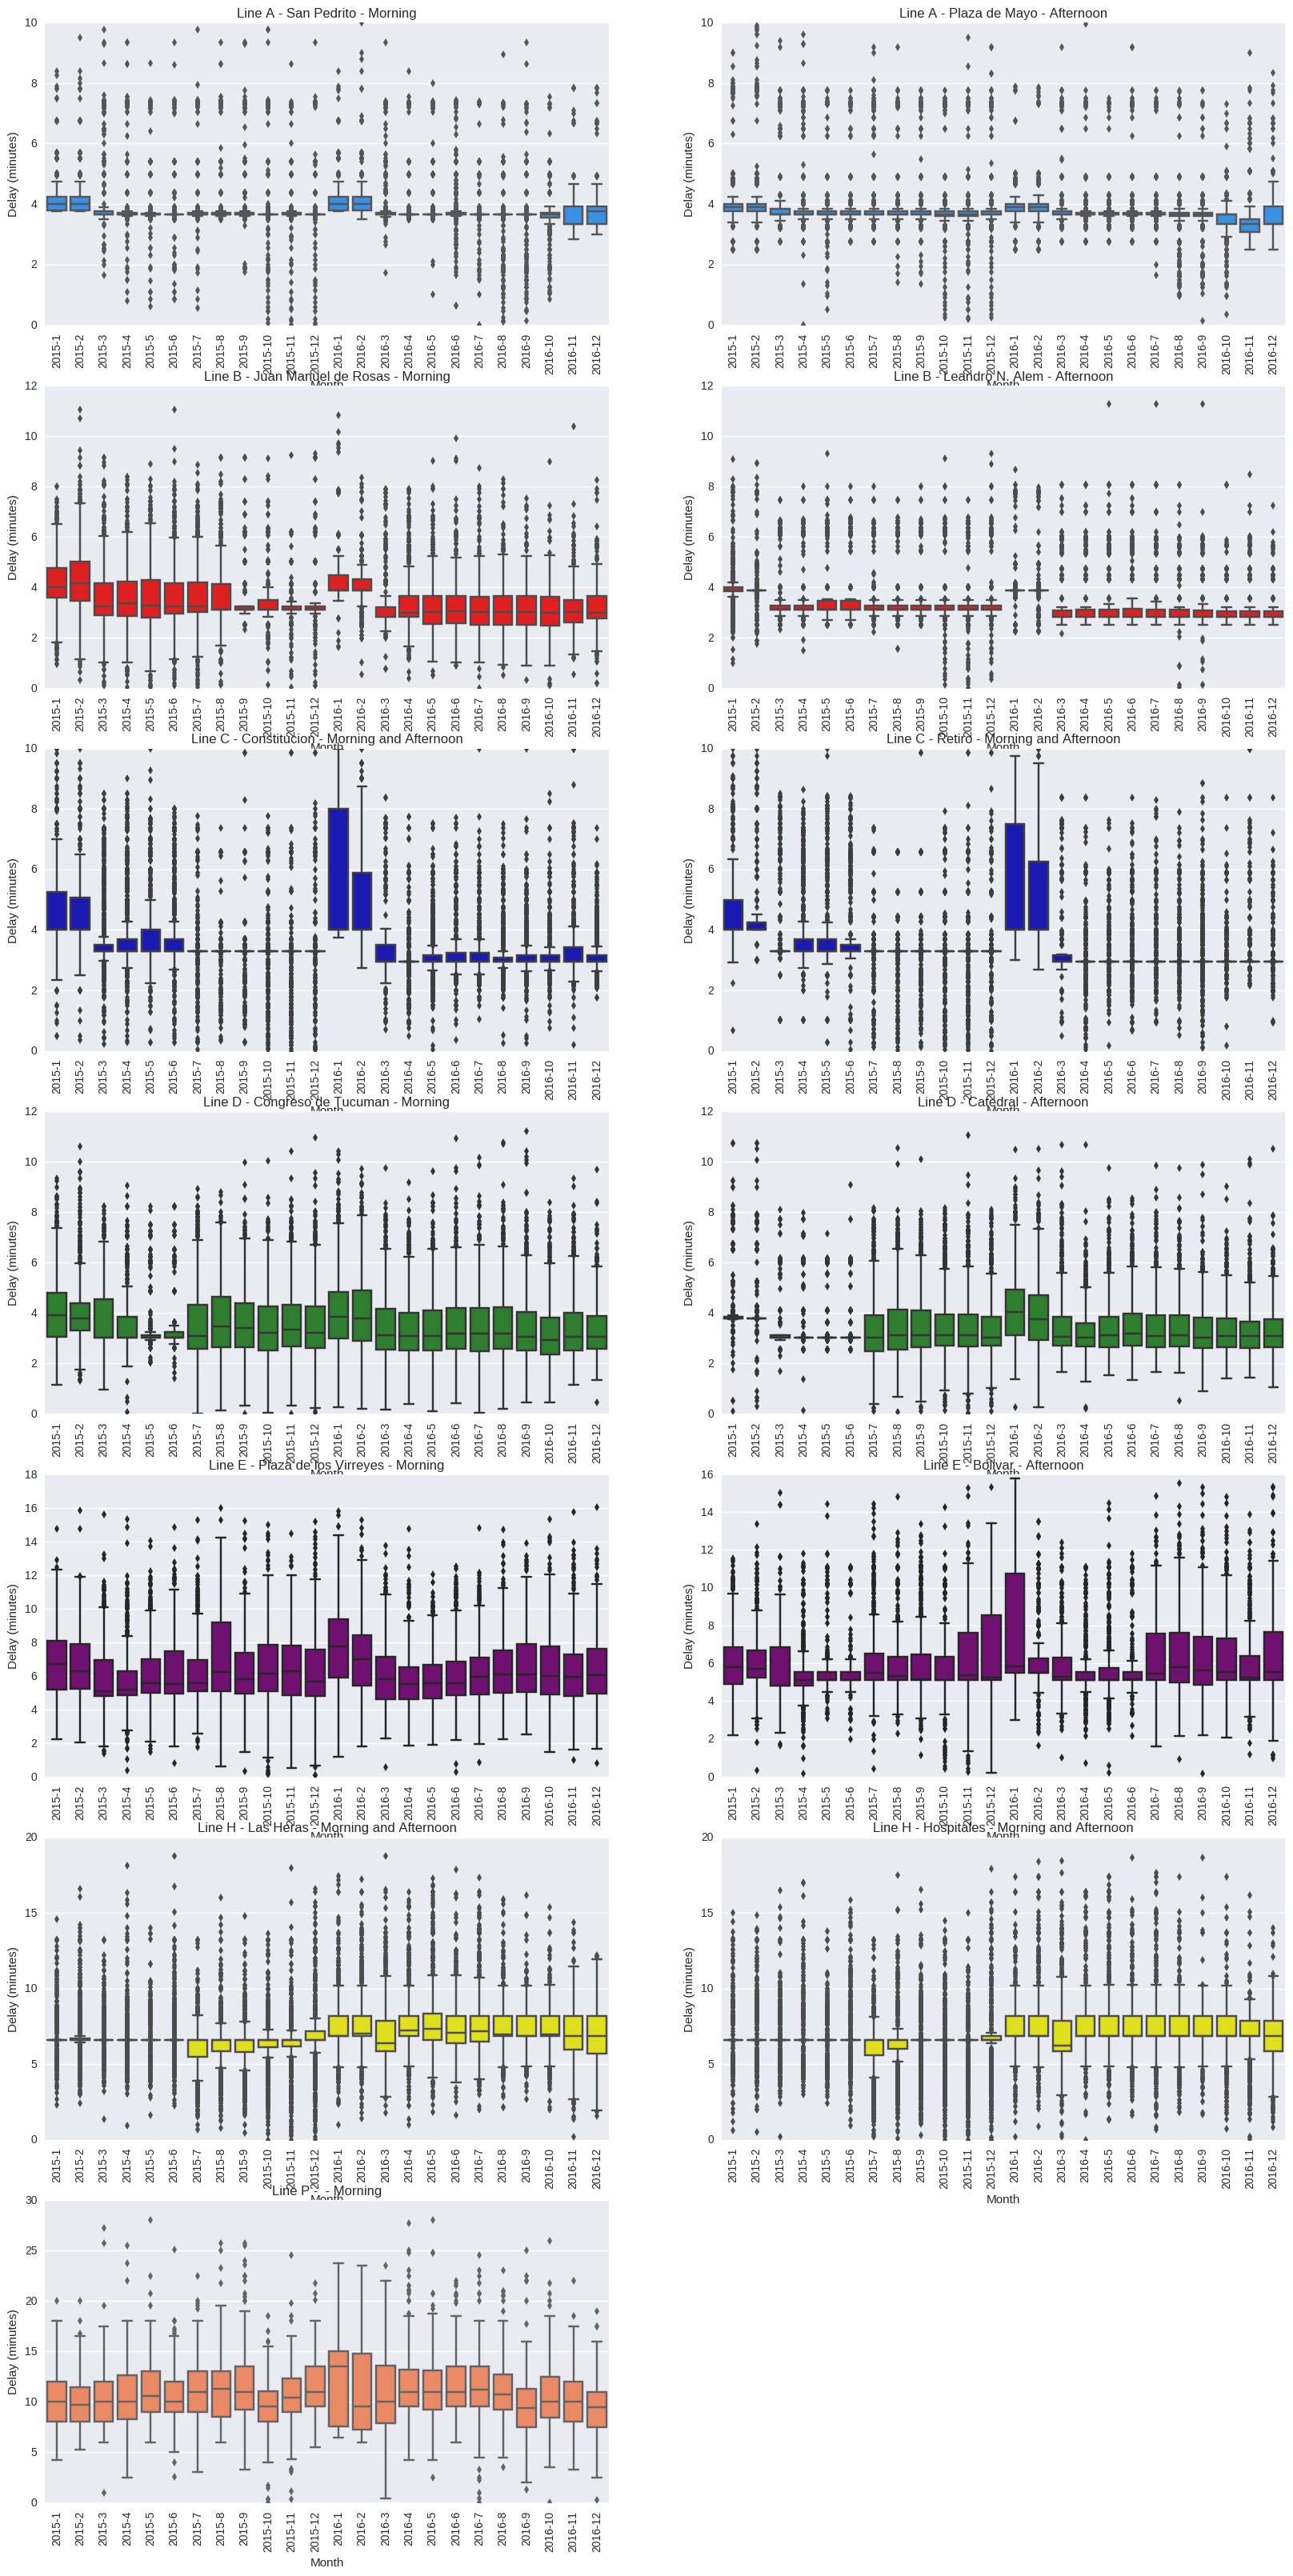

In [43]:
fig = plt.figure(figsize=(20,40))
plotId = 1
for lineId in range(len(lines)):
    line = lines[lineId]
    color = lineColors[line]        
    #print line, color 
    for i in [1,2]:
        terminal = stationsNames[line][i]
        
        if line == 'P' and i == 2 :
            break
            
        #print terminal 
        plotMask = (waitingTime.line == line) & (waitingTime.terminal == i)
        #print sum(plotMask), len(plotMask)
        
               
        if (line != 'C' and line != 'H'): #radial lines selection for rush hour depending on terminal
            if i == 1:
                plotMask = plotMask & waitingTime.rushMorning
                rushTime = 'Morning'
            else:
                plotMask = plotMask & waitingTime.rushEvening
                rushTime = 'Afternoon'
        else:
            plotMask = (plotMask & (waitingTime.rushEvening | waitingTime.rushMorning))
            rushTime = 'Morning and Afternoon'
           
        ax = fig.add_subplot(7,2,plotId)
        ax = sns.boxplot(waitingTime.month[plotMask],waitingTime.delayInt[plotMask],color=color)
        ax.set_xlabel('Month')
        ax.set_ylabel('Delay (minutes)')
        ax.set_xticklabels(waitingTime.month[plotMask].unique(),rotation='vertical')
        ax.set_title('Line ' + line + ' - ' + terminal + ' - ' + rushTime)
        plotId += 1

fig.savefig('../img/plotAllLines.png')
